# Preview of next two weeks

1. Today: Clustering algorithms and introduction to topic models
2. Friday: Topic models
3. Monday: <img src="https://upload.wikimedia.org/wikipedia/commons/8/83/Emergency_Light.gif" width=50/> Awesome guest lecture by Liz <img src="https://upload.wikimedia.org/wikipedia/commons/8/83/Emergency_Light.gif" width=50/>  who will be presenting on the linguistics of and computational problems posted by ambiguous words (relevant for the homework) 
4. Wednesday: Contextual language models (e.g., ELMo, BERT)
5. Friday: Context, composition, and multiword expression extraction

# Algorithms and models for clustering documents

Often, we are interested in understanding whole **documents** rather than individual words, or in characterizing a dataset that we have, rather than the words within it.

That is, **building good word vectors is often a means to an end**. What we often want is better representations of documents.

A **document** can be defined as any longer collection of language that we wish to work with. This could include, e.g., a webpage, a tweet, a chapter within novel, etc. Documents are usually at least the length of one utterance or sentence-like object, and often more.

## One approach: Treat documents like "big words"

For various reasons, we might want all documents to live in a standard space. In many real-world analyses, the bag-of-words representation is powerful on its own. But, if we want to create **document embeddings** or **latent representations** of documents, we often want a representation that looks just like word vectors because this simplifies our math.

For example, a document can be thought of as a **sum** of its component words, or an **average** (if we are worried about longer documents vs. shorter ones). 

## Today: Clustering LSA document vectors and topic models

In the case of LSA and topic modeling, we can obtain lower-dimensional representations of documents, but of very different kinds. LSA will give us a float vector in which each dimension corresponds to a point along a latent dimension learned by PCA. Because the values the model gets are real-valued, this is well-suited to many geometric clustering algorithms.

## Some approaches we have already tried

Last class, we discussed how to generate document embeddings using matrix multiplication in Latent Semantic Analysis, and how the Continuous Bag-of-Words (CBOW) model (one instantiation of `word2vec`) also generates word and document representations.

We also found that it is possible to see how strongly a document is associated with a topic that PCA learns when building LSA vectors. French documents have high "French dimension" scores, machine translation abstracts have high "machine translation dimension" scores, etc.
* This is because we can multiply a **bag-of-words representation** by a **projection matrix** to obtain a lower-dimensional representation of a document (an **embedding**)



## Remember what the shape is of those three matrices?

* A bag-of words representation for one document is $1 \times |V|$ where $|V|$ is the number of vocabulary terms
* The projection matrix contains $k$-dimensional word vectors for all $v \in V$, so $|V| \times k$
* The $|V|$s match, leaving you with a $1 \times k$ matrix (a lower-dimensional embedding)

### Document vector representation tips

* LSA <u>sums</u> word vectors to produce a document embedding
* `word2vec` will <u>average</u> word vectors to produce a document embedding
* The word embeddings in `word2vec` come from the input to the hidden layer (so the first matrix in its architecture -- see previous notebook for details)

## Principal component analysis

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/1280px-GaussianScatterPCA.svg.png" width=400>

In the above image, we have a two-dimensional plot showing a rough oval shape. Principal component analysis (PCA) tries to learn the axes that best characterize this oval. So, it will try to find the longest axis first. Then, it will try to find the next-longest axis in the oval. Each axis is constrained to be independent and orthogonal from the others -- which means that the dimensions are not correlated with each other.

In the above picture, PCA learns the two orthogonal (90º) axes represented by the black arrows projected over the scatterplot.

Our **projection matrix** allows us to turn any document into a lower-dimensional representation. Let's do this with our abstracts again.


### Code for visualization of the abstract topics today -- one way of assessing clusters

In [ ]:
!pip install umap-learn

In [2]:
import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import drive, files
# new
from umap import UMAP
from plotnine import *
import pandas as pd

abstract_file = files.upload()

abstracts = abstract_file['abstracts.tsv'].decode("utf-8").split('\n')

nltk_stops = stopwords.words("english")
missing_stops = ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would']
stop_words = nltk_stops + missing_stops

vectorizer = CountVectorizer( # instantiate sparse matrix-creator
    tokenizer=word_tokenize, # with our tokenization algorithm
    stop_words=stop_words, # typically remove stop words
    lowercase=True) # optionally lowercase words
# basically just one line to get a giant matrix
bow_abstracts = vectorizer.fit_transform(abstracts)

pca = TruncatedSVD(n_components=25)
document_embeddings = pca.fit_transform(bow_abstracts)
print(document_embeddings)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving abstracts.tsv to abstracts.tsv
[[ 4.13815811e+00  1.11158793e+01 -3.03775535e-01 ...  1.69956359e-02
  -1.45883491e-01 -1.36128732e+00]
 [ 3.21875736e+00  8.60545633e+00  1.73131587e+00 ... -5.35446068e-01
   1.80535831e-01  1.11060640e-01]
 [ 3.10500404e+00  8.49311420e+00  5.39657453e-01 ... -8.36467123e-01
   3.03364853e-01 -1.65362207e-01]
 ...
 [ 3.04857838e+01  1.25238543e+00  4.79190602e+00 ...  4.81378600e-01
   3.56106302e+00  2.97159188e+00]
 [ 7.30122149e+00  1.31503462e+00  1.47305078e+00 ...  2.00346830e-01
   6.84948318e-01  8.51532503e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]]


## Relationship between PCA and clustering

PCA identifies the dimensions that best **pull apart** documents from each other. It is usually trying to find components (dimensions) that encode each **word** better. Each dimension in PCA will look like a cluster, but it does not have to. 

Clustering, however, usually requires assigning data points to a "group." Clustering algorithms can be both **supervised** and **unsupervised**. Today we will discuss two unsupervised algorithms. Before we talk about how these algorithms work, I would like you to take a peak at our abstracts.

The figures below tell us about "where" each document (from the embeddings above) sits with respect to every other document. That is, we can compute document-to-document distances. We did some fancy magic to put these results into two dimensions, but the idea is basically the same -- we want to see how much the latent dimensions (e.g., learned by PCA) **differentiate** different classes of documents that we can conceptualize as "clusters."

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 14 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  f"A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.\n"


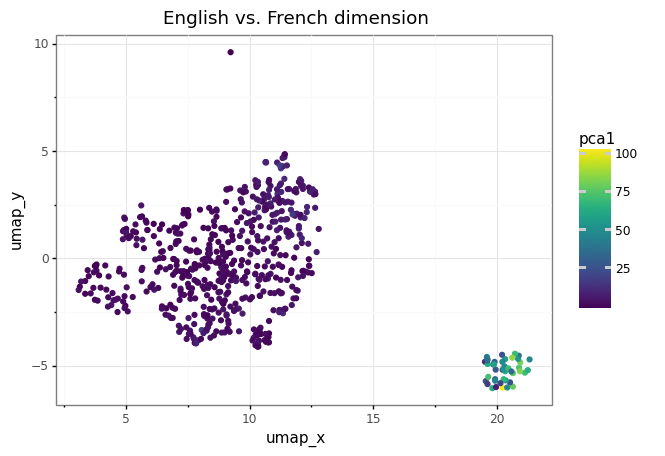

<ggplot: (8733870209937)>


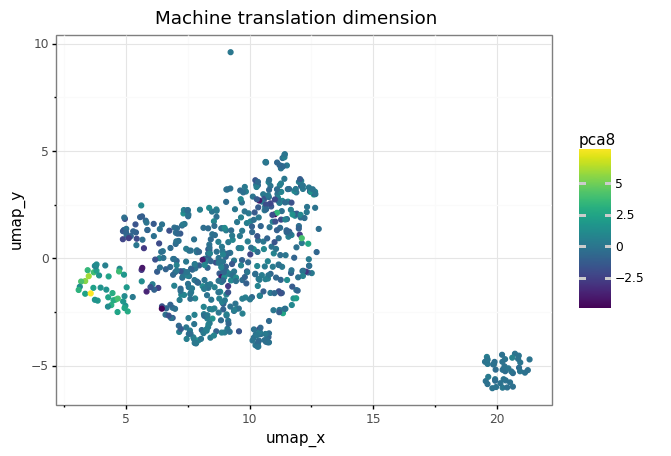

<ggplot: (8733868503341)>


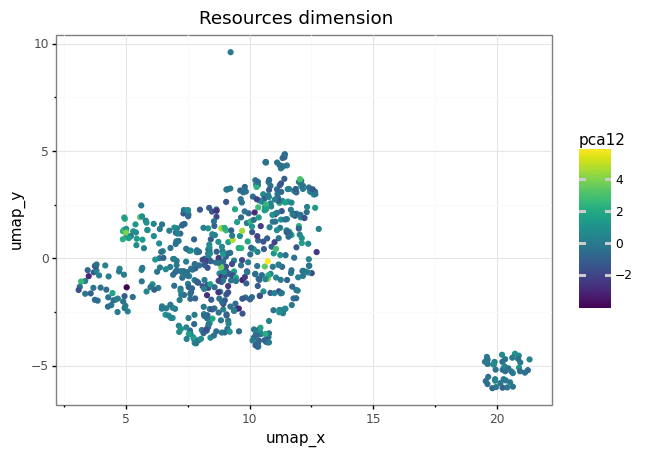

<ggplot: (8733869891317)>


In [3]:
#@title
two_d_abstracts = UMAP(metric='correlation', n_components=2).fit_transform(document_embeddings)
umap_vecs = pd.DataFrame(two_d_abstracts, columns=['umap_x', 'umap_y'])
umap_vecs['pca1'] = document_embeddings[:, 0]
umap_vecs['pca8'] = document_embeddings[:, 8]
umap_vecs['pca12'] = document_embeddings[:, 12]
sample_df = umap_vecs.sample(n=600)
print(ggplot(sample_df,
             aes(x='umap_x', y='umap_y', color='pca1'))
+ ggtitle("English vs. French dimension")
+ geom_point() + theme_bw())
print(ggplot(sample_df,
             aes(x='umap_x', y='umap_y', color='pca8'))
+ ggtitle("Machine translation dimension")
+ geom_point() + theme_bw())
print(ggplot(sample_df,
             aes(x='umap_x', y='umap_y', color='pca12'))
+ ggtitle("Resources dimension")
+ geom_point() + theme_bw())

## Clustering algorithms

The goal of a clustering algorithm is to assign a point to a **cluster** or a group. Clusters have a geometric interpretation as well. Putting vector-valued data into a clustering algorithm can give you labels where you might not have had any before. Because of this, clustering is usually **unsupervised**. However, supervised clustering methods exist as well. `scikit-learn` has a huge repository of clustering algorithms: https://scikit-learn.org/stable/modules/clustering.html

### K-means algorithm
1. Randomly assign positions to $k$ clusters of your choosing
  - Cluster **centroids** can be defined ahead of time or more intelligently
  - Number of centroids is determined by the researcher
2. Greedily assign each point (e.g., a document) to a cluster based on which cluster it is closest to
  - Optimizes for Euclidean distance
  - Side effect: K-means works best if spaces are circle-shaped
3. Iteratively optimizes the locations of clusters until the assignments stop changing

Neat video to visualize k-means: https://www.youtube.com/watch?v=BVFG7fd1H30

## Other clustering algorithms

### Gaussian mixture models (GMMs)
* Assigns points to different clusters based on their **probabilities** 
* A document could be 70% likely to be Topic A, or 20% likely to be Topic B, and so on.
* Allows for shapes of data to not be non-circular (e.g., like PCA)
* Very useful for allowing a data point to belong to multiple clusters
* Can automatically spawn new categories if it improves the fit to the data

Great technical introduction to GMMs: https://www.youtube.com/watch?v=qMTuMa86NzU

### Hierarchical 

Often called "agglomerative clustering", this family of algorithms identifies a hierarchy of topics. For language data, this could be like:

* Grouping together chapters belonging to the same book
* Grouping together similar books belonging to the same genre
* Grouping together books written by the same author

Some clustering methods, such as dendrograms, can help you visualize the relationship between documents, but nevertheless benefit from some knowledge or labels.

Hierarchical versions of topic models also exist. Known as Hierarchical Dirichlet Processes, these extend Latent Dirichlet Allocation to a potentially highly nested space. They also have some fun names that help to visualize how the language data is organized. If you share food (words) with friends (topics) when you go to restaurants, these labels will make more sense to you.

* Chinese restaurant process
* Chinese restaurant franchise process
* Indian buffet process

These hierarchical models are outside the scope of this course, but represent some of the most transparent clustering models.



#Topic models (Latent Dirichlet Allocation)

Topic modeling algorithms will also give us a float vector, but each dimension corresponds to a **probability** that that document is assigned to that topic. Indeed, topic models capture the idea that a document can be composed of multiple types of words. 

Remember the topic discussion from the first week of class? Here's that analysis! We will go through more of the math on Friday.

In [9]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk import word_tokenize

tokenized_abstracts = [word_tokenize(x) for x in abstracts]

bib_dictionary = Dictionary(tokenized_abstracts)
bib_corpus = [bib_dictionary.doc2bow(text) for text in tokenized_abstracts]

In [13]:
model = LdaModel(corpus=bib_corpus, num_topics=10)

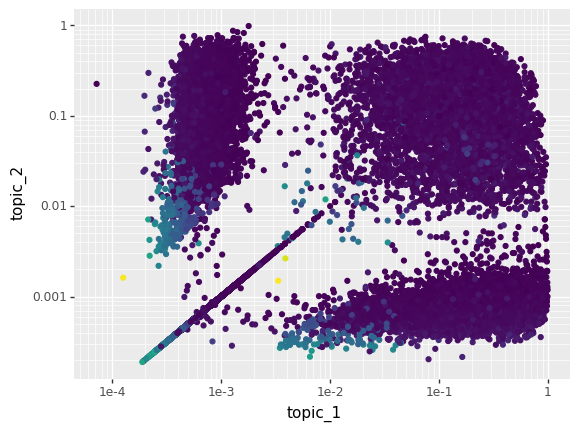

<ggplot: (8733832820573)>


In [42]:
#@title Munging some data to show you the topics
all_topic_scores = model.get_document_topics(bib_corpus, minimum_probability=0)
all_abstract_scores = []
for doc in all_topic_scores:
    abstract_scores = []
    for topic_idx, topic_score in enumerate(doc):
        score_only = topic_score[-1]
        abstract_scores.append(score_only)
    all_abstract_scores.append(abstract_scores)
topic_scores_df = pd.DataFrame(all_abstract_scores, columns=['topic_' + str(i) for i in range(10)])
print(ggplot(topic_scores_df, aes(x='topic_1', y="topic_2", color=document_embeddings[:, 0])) + geom_point() + scale_x_log10() + scale_y_log10() + guides(color=False))